<a href="https://colab.research.google.com/github/Arpitkamal/Deep-Learning---Deep-Convolutional-Neural-Networks/blob/master/LargeCNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Outline

*   Loading datasets - Transforming images
*   VGG-16 with modification to network head
*   using pre-trained models
*   Storing intermediate models
*   Resnet
*   Inception v3
*   Exercise





In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision 
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim #for backpropagation

In [2]:
device = torch.device("cuda:0")
print(device)

cuda:0


# Dataset, transforms and visualisation

In [3]:
transform_train = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])

transform_test = transforms.Compose([
         transforms.RandomResizedCrop(224),  #resizing and croping
         transforms.ToTensor(),              #converted to tensor
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #Normalization                         
])



In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True,
                                        transform= transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
num_classes = 10

In [6]:
batch_size = 4

In [7]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
dataiter = iter(trainloader) #instantiating iterator for trainloader 
images, labels = dataiter.next() # return one batch

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 224, 224])
torch.Size([3, 224, 224])
3


In [9]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5                #converting the image to numpy and unnormalizing it 
  plt.figure(figsize=(batch_size, 1))          #(width, height)
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [10]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

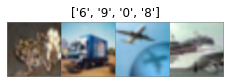

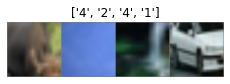

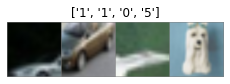

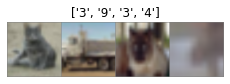

In [11]:
for i in range(4):
  show_batch_images(trainloader)

# Creating VGG-16

In [12]:
from torchvision import models

In [13]:
vgg = models.vgg16_bn()

In [14]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [15]:
print(vgg.features[0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [16]:
print(vgg.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


We have to change output features to 10

In [17]:
final_in_features = vgg.classifier[6].in_features
mod_classifier = list(vgg.classifier.children())[:-1]  #excluding last linear layer
mod_classifier.extend([nn.Linear(final_in_features, num_classes)]) # num_classes is defined to be 10 earlier
print(mod_classifier)

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=4096, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=4096, out_features=10, bias=True)]


In [18]:
vgg.classifier = nn.Sequential(*mod_classifier) #defining modified classifier
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Training the VGG 

In [19]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [20]:
def evaluation(Dataloader, model):
  total, correct = 0,0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total  

In [21]:
vgg = vgg.to(device)            # taking model to device 
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [24]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % epoch, max_epochs, evaluation(testloader, vgg),
        evaluation(trainloader, vgg))
  
plt.plot(loss_epoch_arr)
plt.show()  

Iteration: 0/3125, Loss: 2.39
Iteration: 100/3125, Loss: 3.25
Iteration: 200/3125, Loss: 2.15
Iteration: 300/3125, Loss: 2.26
Iteration: 400/3125, Loss: 2.19
Iteration: 500/3125, Loss: 2.51
Iteration: 600/3125, Loss: 2.31
Iteration: 700/3125, Loss: 2.28
Iteration: 800/3125, Loss: 2.29
Iteration: 900/3125, Loss: 2.20
Iteration: 1000/3125, Loss: 2.33
Iteration: 1100/3125, Loss: 2.21
Iteration: 1200/3125, Loss: 2.26
Iteration: 1300/3125, Loss: 2.19
Iteration: 1400/3125, Loss: 2.52
Iteration: 1500/3125, Loss: 2.13
Iteration: 1600/3125, Loss: 2.08
Iteration: 1700/3125, Loss: 2.07
Iteration: 1800/3125, Loss: 2.65
Iteration: 1900/3125, Loss: 2.19
Iteration: 2000/3125, Loss: 2.23
Iteration: 2100/3125, Loss: 2.26


KeyboardInterrupt: ignored

# Freeze layers of Convolutional Operations(Transfer Learning)

In [25]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

In [26]:
vgg = models.vgg16_bn(pretrained=True)  #predtrained model downloaded

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


In [29]:
for param in vgg.parameters():      #if am doing backpropagation then don't update weight and bias(frozen paramerters)
  param.requires_grad = False      

Another way of changing last layer to 10 output features

In [30]:
final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)

In [31]:
vgg = vgg.to(device)            # taking model to device 
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(vgg.parameters(), lr=0.05)

In [32]:
loss_epoch_arr = []
max_epochs = 1

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % epoch, max_epochs, evaluation(testloader, vgg),
        evaluation(trainloader, vgg))
  
plt.plot(loss_epoch_arr)
plt.show()  

Iteration: 0/3125, Loss: 2.35
Iteration: 100/3125, Loss: 1.53
Iteration: 200/3125, Loss: 2.38
Iteration: 300/3125, Loss: 1.98
Iteration: 400/3125, Loss: 2.40
Iteration: 500/3125, Loss: 2.33
Iteration: 600/3125, Loss: 3.18
Iteration: 700/3125, Loss: 2.24
Iteration: 800/3125, Loss: 1.82
Iteration: 900/3125, Loss: 1.82
Iteration: 1000/3125, Loss: 2.00
Iteration: 1100/3125, Loss: 2.24
Iteration: 1200/3125, Loss: 2.30
Iteration: 1300/3125, Loss: 1.57
Iteration: 1400/3125, Loss: 2.28
Iteration: 1500/3125, Loss: 2.16
Iteration: 1600/3125, Loss: 2.07
Iteration: 1700/3125, Loss: 2.15
Iteration: 1800/3125, Loss: 1.07
Iteration: 1900/3125, Loss: 2.26
Iteration: 2000/3125, Loss: 1.64
Iteration: 2100/3125, Loss: 2.70
Iteration: 2200/3125, Loss: 1.69
Iteration: 2300/3125, Loss: 2.58
Iteration: 2400/3125, Loss: 2.89


KeyboardInterrupt: ignored

# With model copies

In [35]:
import copy

In [37]:
loss_epoch_arr = []
max_epochs = 1

min_loss = 1000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs = vgg(inputs)              #forward pass
    loss = loss_fn(outputs, labels)   #compute loss
    loss.backward()                   #backward pass
    opt.step()                       #updating the weights

    if min_loss > loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(vgg.state_dict())   # making the deep copy of best model
      print('Min loss %0.2f'% min_loss)

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))  
 
    del inputs, labels, outputs
    torch.cuda.empty_cache()          #to make sure memory usage in GPU is small

    if i % 100 == 0:
      print('Iteration: %d/%d, Loss: %0.2f' %(i, n_iters, loss.item()))
    
  loss_epoch_arr.append(loss.item())

  

Min loss 2.32
Iteration: 0/3125, Loss: 2.32
Iteration: 0/3125, Loss: 2.32
Min loss 1.92
Min loss 1.23
Min loss 0.80
Min loss 0.69
Iteration: 100/3125, Loss: 2.26
Iteration: 100/3125, Loss: 2.26
Iteration: 200/3125, Loss: 2.19
Iteration: 200/3125, Loss: 2.19
Min loss 0.62
Iteration: 300/3125, Loss: 2.20
Iteration: 300/3125, Loss: 2.20
Iteration: 400/3125, Loss: 0.71
Iteration: 400/3125, Loss: 0.71
Iteration: 500/3125, Loss: 1.18
Iteration: 500/3125, Loss: 1.18
Iteration: 600/3125, Loss: 2.30
Iteration: 600/3125, Loss: 2.30
Iteration: 700/3125, Loss: 0.75
Iteration: 700/3125, Loss: 0.75
Iteration: 800/3125, Loss: 1.53
Iteration: 800/3125, Loss: 1.53
Iteration: 900/3125, Loss: 1.80
Iteration: 900/3125, Loss: 1.80
Iteration: 1000/3125, Loss: 2.84
Iteration: 1000/3125, Loss: 2.84
Iteration: 1100/3125, Loss: 1.86
Iteration: 1100/3125, Loss: 1.86
Iteration: 1200/3125, Loss: 2.68
Iteration: 1200/3125, Loss: 2.68
Iteration: 1300/3125, Loss: 1.27
Iteration: 1300/3125, Loss: 1.27
Iteration: 1400/

In [38]:
vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg), evaluation(testloader, vgg))

NameError: ignored